In [1]:
!pwd
import os
os.chdir('..')
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
from bilevel.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/jupyter-kriach/md_github_lat/multigroupcode/multigroup-code/iclr_res


In [2]:
%%time
df_adult = pd.read_csv('./data_small/adult_reconstruction.csv')

numeric_all = ['hours-per-week', 'age', 'capital-gain', 'capital-loss', 'education-num', 'income']
cat_feat =  ['workclass', 'marital-status', 'relationship', 'native-country', 'occupation', 'race', 'sex']

df_adult.drop(['education'], axis = 1, inplace=True)
df_adult_mm = numeric_scaler(df_adult, numeric_all)
df_adult_mm_oh = one_hot(df_adult_mm, cat_feat)
df_adult_mm_oh.drop(cat_feat, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_adult_mm_oh = df_adult_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_adult_mm_oh.head()

A_t_age = pd.concat([df_adult['age'] <= 35,  # young
        (df_adult['age'] > 35) & (df_adult['age'] <= 50), # middle
        df_adult['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])

A_t_edu = pd.concat([df_adult['education-num'] <= 9, df_adult['education-num'] >= 10], axis = 1, 
                keys = ['HighSchool&less', 'College&more'])

A_t_sex = pd.concat([df_adult['sex'] == 'Male', df_adult['sex'] == 'Female'], axis = 1, keys = ['Male', 'Female'])

A_t_race = pd.concat([df_adult['race'] == 'White', df_adult['race'] == 'Asian-Pac-Islander',
                      df_adult['race'] == 'Amer-Indian-Eskimo', df_adult['race'] == 'Other',
                      df_adult['race'] == 'Black'], axis = 1, keys = ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'])

A_t_adult_groups = pd.concat([A_t_age, A_t_edu, A_t_sex, A_t_race], axis=1)
A_t_adult_groups['always_on'] = True
A_t_adult_groups *= 1
A_t_adult_groups.sum(axis=0)

CPU times: user 96.6 ms, sys: 41 ms, total: 138 ms
Wall time: 136 ms


young                 22792
middle                16881
old                    9858
HighSchool&less       22584
College&more          26947
Male                  33174
Female                16357
White                 42441
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      471
Other                   406
Black                  4694
always_on             49531
dtype: int64

In [3]:
%%time
from bilevel.Groupwise_seedruns import BuildGroupwise_diffseeds
ds_obj = BuildGroupwise_diffseeds(df_adult_mm_oh, 'income', A_t_adult_groups)
ds_obj.build_all_seeds()
ds_obj.build_df_res()

100%|██████████| 49531/49531 [00:21<00:00, 2292.79it/s]


CPU times: user 33min 13s, sys: 1min 15s, total: 34min 28s
Wall time: 4min 18s


In [4]:
# subgroups_list = [['young', 'middle', 'old'], ['HighSchool&less', 'College&more'], ['Male', 'Female'],
# ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'], ['always_on']]

# from bilevel.Groupwise_seedruns import plot_subgroups
# plot_subgroups(ds_obj, subgroups_list)

In [4]:
%%time
ds_obj.build_regret_curve()

CPU times: user 10min 17s, sys: 21.5 s, total: 10min 38s
Wall time: 1min 19s


In [5]:
# with open('adult_gw_ob.pkl', 'rb') as handle:
#     ds_obj = pickle.load(handle)

# adult_gw = load_ob('adult_gw_ob.pkl')

In [6]:
save_ob('adult_gw_expcloss.pkl', ds_obj)

young 22792


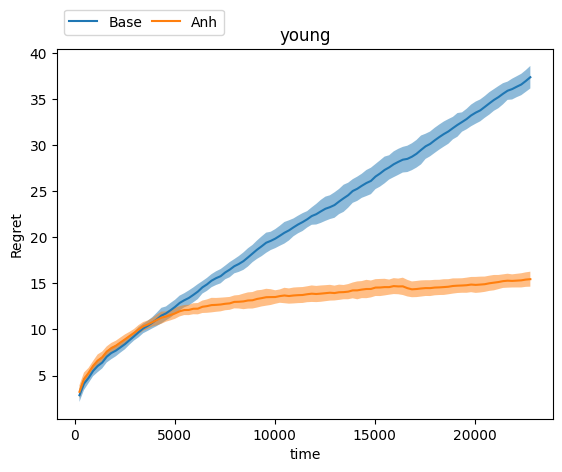

middle 16881


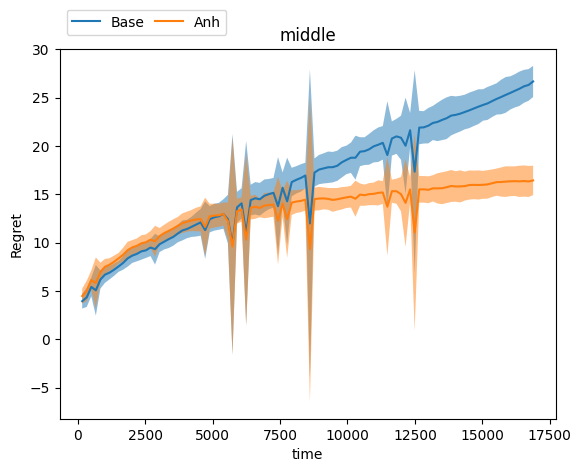

old 9858


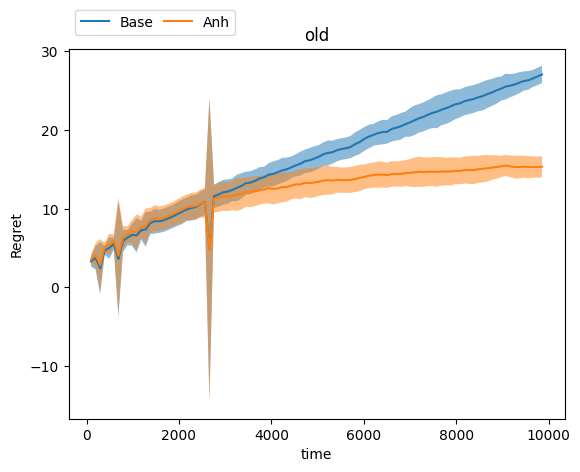

HighSchool&less 22584


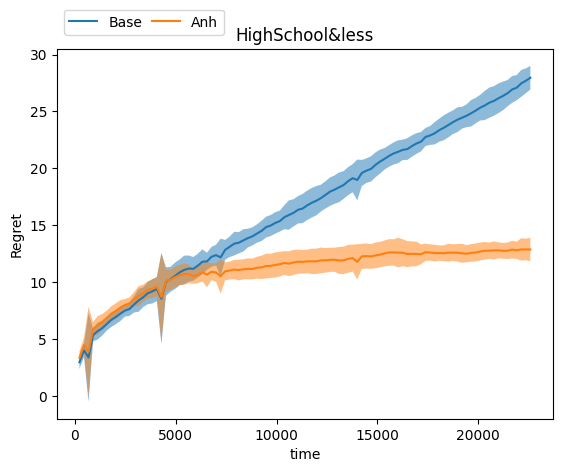

College&more 26947


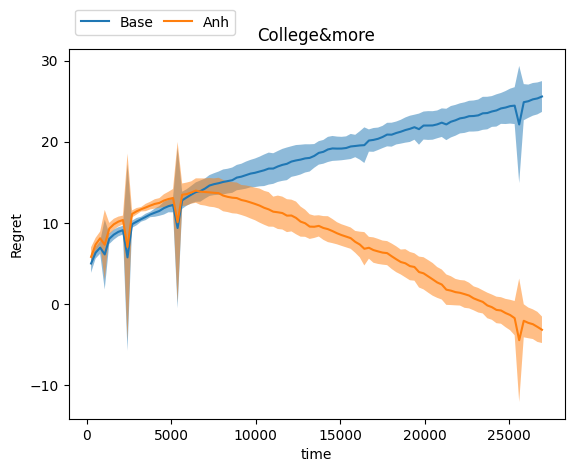

Male 33174


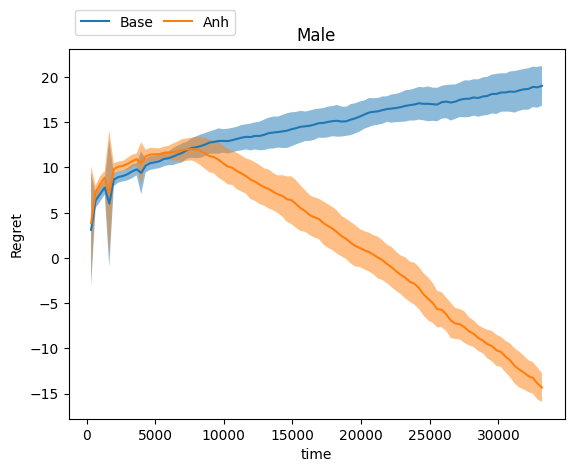

Female 16357


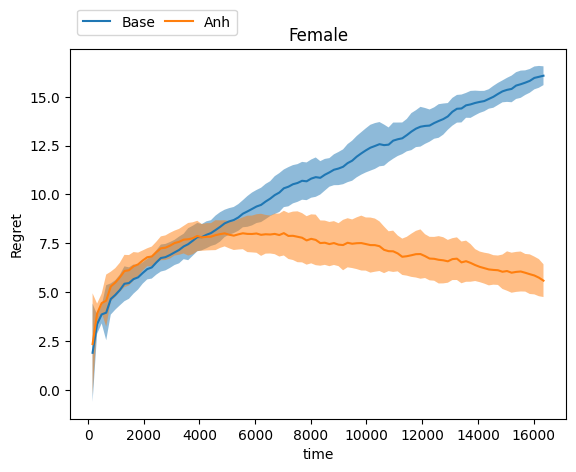

White 42441


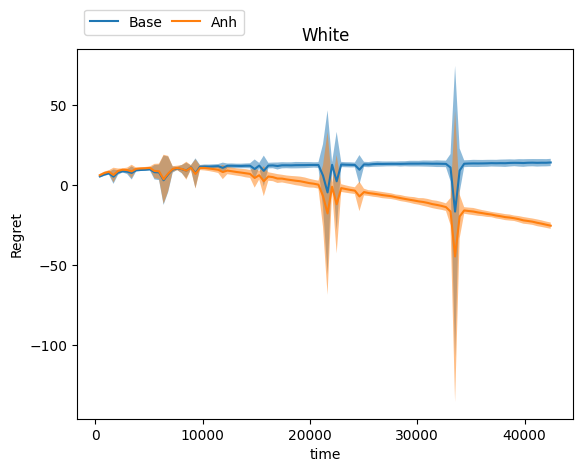

Asian-Pac-Islander 1519


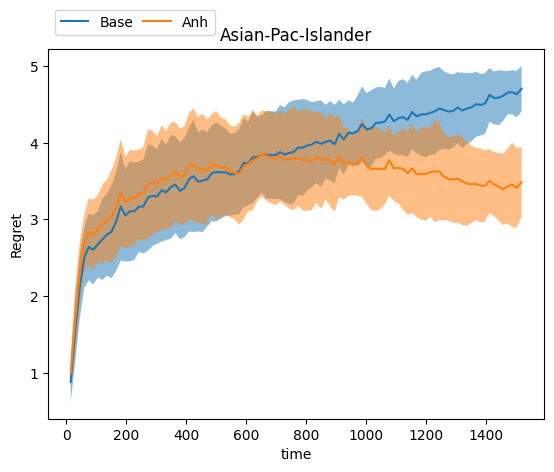

Amer-Indian-Eskimo 471


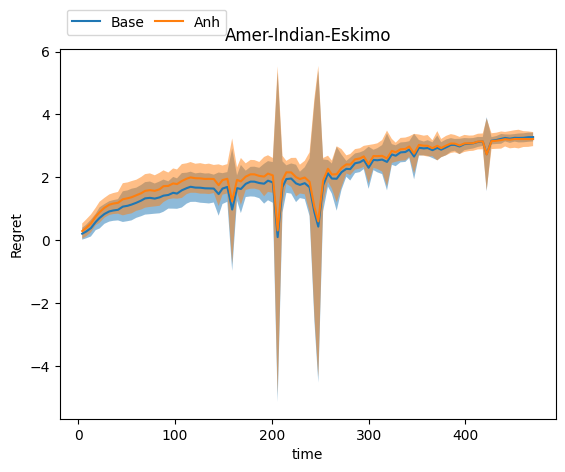

Other 406


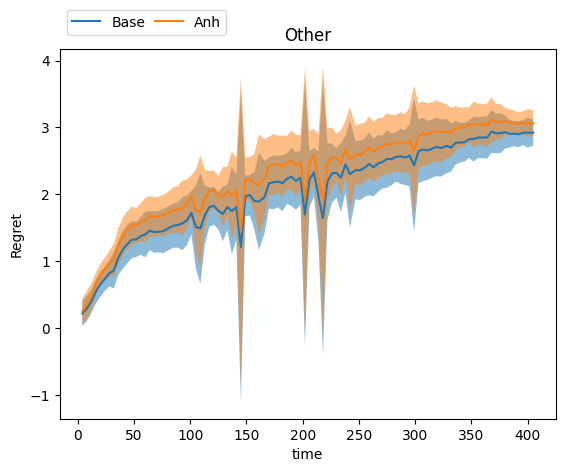

Black 4694


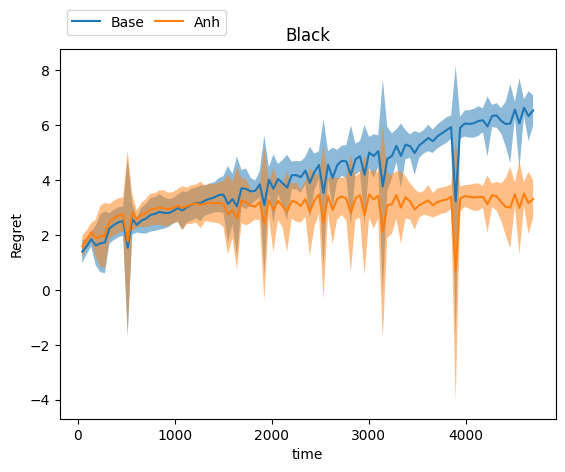

always_on 49531


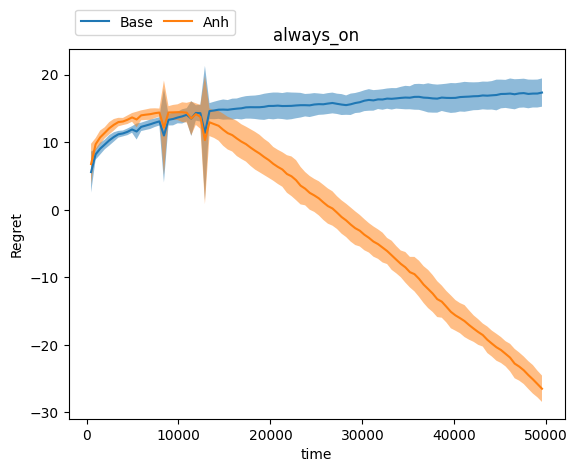

In [10]:
from bilevel.Groupwise_seedruns import plot_regret_curve_with_std # with clipped y_vals of the least squares predictor
plot_regret_curve_with_std(ds_obj, 'adult_income_plots_exploss')

In [ ]:
# Testing best in hindsight vs ridge batch

In [8]:
def performance_diff(ds_obj):
    df_res = pd.concat([ds_obj.df_base_meansd, ds_obj.df_Anh_meansd], axis=1)
    df_res['base_minus_Anh'] = df_res['mean_base'] - df_res['mean_Anh']
    df_res['discount_from_base'] = (df_res['base_minus_Anh'] / df_res['mean_base'])*100
    return df_res

In [10]:
performance_diff(ds_obj)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
young,450.168510,1.276885,428.277620,0.847336,21.890891,4.862821
middle,624.831559,1.705613,614.592733,1.611411,10.238826,1.638654
old,434.394247,1.149837,422.683228,1.412409,11.711019,2.695943
HighSchool&less,526.493605,1.094041,511.408555,1.089702,15.085050,2.865191
College&more,982.900711,1.998353,954.145025,1.724671,28.755686,2.925594
Male,1182.621030,2.315097,1149.271282,1.681161,33.349748,2.819986
Female,326.773286,0.503465,316.282298,0.891207,10.490988,3.210479
White,1326.996324,2.398741,1287.520499,2.090025,39.475825,2.974825
Asian-Pac-Islander,59.481154,0.288898,58.263756,0.465740,1.217398,2.046696
Amer-Indian-Eskimo,12.380835,0.144627,12.317055,0.236884,0.063779,0.515144


In [9]:
performance_diff(ds_obj)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
young,450.168510,1.276885,428.277620,0.847336,21.890891,4.862821
middle,624.831559,1.705613,614.592733,1.611411,10.238826,1.638654
old,434.394247,1.149837,422.683228,1.412409,11.711019,2.695943
HighSchool&less,526.493605,1.094041,511.408555,1.089702,15.085050,2.865191
College&more,982.900711,1.998353,954.145025,1.724671,28.755686,2.925594
Male,1182.621030,2.315097,1149.271282,1.681161,33.349748,2.819986
Female,326.773286,0.503465,316.282298,0.891207,10.490988,3.210479
White,1326.996324,2.398741,1287.520499,2.090025,39.475825,2.974825
Asian-Pac-Islander,59.481154,0.288898,58.263756,0.465740,1.217398,2.046696
Amer-Indian-Eskimo,12.380835,0.144627,12.317055,0.236884,0.063779,0.515144
